10.	Загрузить датасет taxi.csv.
-	Изучить данные. Отобразить общую информацию по признакам. Описать свои наблюдения.
-	Выявить пропуски, а также возможные причины их возникновения. Решить, что следует сделать с ними. Описать свои наблюдения и решение.
-	Оценить и описать зависимость переменных между собой.
-	Определите стратегию преобразования категориальных признаков для дальнейшего построения моделей.
-	Найти признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалить лишние, при необходимости.
-	Разделить выборку на обучаемую и тестовую.
-	Обучить несколько моделей, выбрать критерий оценки выбрать наилучшую.
-	Визуализировать результаты.


## Подготовка данных

Подключение библиотек и скриптов

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

# 6. Всякие разности
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

Оптимизация объема памяти, занимаемого датасетом

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Функции

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Загрузка данных**

In [6]:
file = 'taxi.xls'

In [7]:
df = pd.read_csv(file, sep=',')
reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 10.68 MB
Memory usage after optimization is: 3.72 MB
Decreased by 65.2%


,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818844,37.334560,55.814568,37.355011,-1.000,-1.000000,Economy,private,0
1,759733,5,14,6080,358774,55.805344,37.515022,55.819328,37.466396,18.802,25.216999,Standard,private,1
2,416977,6,14,6080,866260,55.813976,37.347687,55.814827,37.354073,6.747,9.800000,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421749,55.743469,37.431129,-1.000,-1.000000,Economy,private,1
4,1120055,4,16,6080,506710,55.803577,37.521603,55.812557,37.527409,12.383,19.250000,Economy,private,1


In [8]:
df.shape

(100000, 14)

In [9]:
df.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.715729,37.497726,55.787930,37.547104,18.393524,23.134911,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135841,1.454347,0.666193,0.467781,41.131313,33.893005,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708652,37.413498,55.708031,37.407116,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772903,37.533665,55.772560,37.532537,10.411500,19.700001,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624112,55.962002,37.624356,30.665251,37.867001,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174095,38.280548,56.311123,38.243607,5234.283203,3958.282959,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   offer_gk                100000 non-null  int32   
 1   weekday_key             100000 non-null  int8    
 2   hour_key                100000 non-null  int8    
 3   driver_gk               100000 non-null  int16   
 4   order_gk                100000 non-null  int32   
 5   driver_latitude         100000 non-null  float32 
 6   driver_longitude        100000 non-null  float32 
 7   origin_order_latitude   100000 non-null  float32 
 8   origin_order_longitude  100000 non-null  float32 
 9   distance_km             100000 non-null  float32 
 10  duration_min            100000 non-null  float32 
 11  offer_class_group       100000 non-null  category
 12  ride_type_desc          100000 non-null  category
 13  driver_response         100000 non-null  int8    
dtypes: ca

### Определение типа задачи

In [11]:
df['driver_response'].value_counts()

0    50752
1    49248
Name: driver_response, dtype: int64

Исходя из результата, мы имеем перед собой задачу классификации

### Поиск номинативных переменных

In [12]:
df.describe(include=['category', 'object', 'bool'])

,offer_class_group,ride_type_desc
count,100000,100000
unique,9,4
top,Economy,private
freq,48335,91207


In [13]:
df['offer_class_group'].value_counts()

Economy     48335
Standard    47288
Premium      1773
Delivery     1290
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

In [14]:
df['ride_type_desc'].value_counts()

private      91207
business      8533
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

### Графики распределения по дням недели и часам внутри одного дня

Text(0.5, 1.0, 'weekday_key')

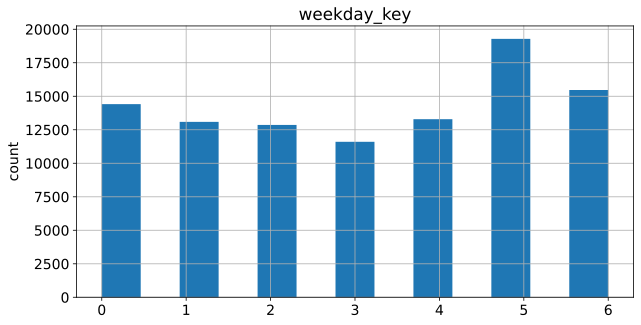

In [15]:
plt.figure(figsize = (10, 5))

df['weekday_key'].hist(bins=13)
plt.ylabel('count')
plt.title('weekday_key')

Text(0.5, 1.0, 'hour_key')

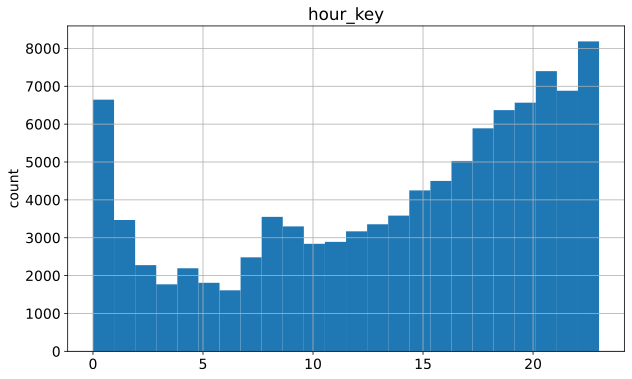

In [16]:
plt.figure(figsize = (10, 6))

df['hour_key'].hist(bins=24)
plt.ylabel('count')
plt.title('hour_key')

### Обработка пропусков

In [17]:
df.isna()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99997,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99998,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [18]:
df.isna().sum()

offer_gk                  0
weekday_key               0
hour_key                  0
driver_gk                 0
order_gk                  0
driver_latitude           0
driver_longitude          0
origin_order_latitude     0
origin_order_longitude    0
distance_km               0
duration_min              0
offer_class_group         0
ride_type_desc            0
driver_response           0
dtype: int64

Пропусков нет, но при этом в столбцах ниже есть значения "-1", с которыми возможно придется работать

In [19]:
df['distance_km'].value_counts()

-1.000000     26207
 0.000000       152
 7.718000        39
 56.446999       35
 11.014000       32
              ...  
 17.797001        1
 35.160000        1
 34.285999        1
 25.167999        1
 43.203999        1
Name: distance_km, Length: 31297, dtype: int64

In [20]:
df['duration_min'].value_counts()

-1.000000     26207
 0.000000       152
 21.466999       65
 56.833000       64
 23.333000       56
              ...  
 88.682999        1
 88.349998        1
 72.650002        1
 85.400002        1
 1.250000         1
Name: duration_min, Length: 4728, dtype: int64

In [21]:
# Также значения "-1" встречаются в столбцах: 
# driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude

**Проведенный анализ показал, что исключая или преобразовывая эти данные, а также введение новых столбцов: например разницы широты и долготы между заказом и водителем приводит к ухудшению метрик моделей**

## Уберем лишние данные

In [22]:
df['offer_gk'].value_counts()

534523    1
513801    1
139921    1
539282    1
799379    1
         ..
927150    1
798127    1
578992    1
318897    1
393216    1
Name: offer_gk, Length: 100000, dtype: int64

In [23]:
df = df.drop(['offer_gk'], axis=1)

In [24]:
df.head()

,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,5,20,6080,174182,55.818844,37.334560,55.814568,37.355011,-1.000,-1.000000,Economy,private,0
1,5,14,6080,358774,55.805344,37.515022,55.819328,37.466396,18.802,25.216999,Standard,private,1
2,6,14,6080,866260,55.813976,37.347687,55.814827,37.354073,6.747,9.800000,Economy,private,0
3,2,6,6080,163522,55.745922,37.421749,55.743469,37.431129,-1.000,-1.000000,Economy,private,1
4,4,16,6080,506710,55.803577,37.521603,55.812557,37.527409,12.383,19.250000,Economy,private,1


## Создадим копию датасета для обработки в catboost

In [25]:
df_mod = df.copy()

## Базовая проверка датасета на различных моделях

### Преобразуем категориальные признаки в числовые для использования в алгоритмах бустинга

Обрабатываем номинативные переменные как бинарные (дамми) переменные

In [26]:
df = pd.concat([df, pd.get_dummies(df.offer_class_group, prefix='offer_class_group_')], axis=1, sort=False)  
df = df.drop(['offer_class_group'], axis=1)

In [27]:
df = pd.concat([df, pd.get_dummies(df.ride_type_desc, prefix='ride_type_desc_')], axis=1, sort=False)  
df = df.drop(['ride_type_desc'], axis=1)

Обрабатываем дни недели как бинарные (дамми) переменные

In [28]:
df = pd.concat([df, pd.get_dummies(df.weekday_key, prefix='weekday_key_')], axis=1, sort=False)  
df = df.drop(['weekday_key'], axis=1)

In [29]:
df.head()

,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response,...,ride_type_desc__affiliate,ride_type_desc__business,ride_type_desc__private,weekday_key__0,weekday_key__1,weekday_key__2,weekday_key__3,weekday_key__4,weekday_key__5,weekday_key__6
0,20,6080,174182,55.818844,37.334560,55.814568,37.355011,-1.000,-1.000000,0,...,0,0,1,0,0,0,0,0,1,0
1,14,6080,358774,55.805344,37.515022,55.819328,37.466396,18.802,25.216999,1,...,0,0,1,0,0,0,0,0,1,0
2,14,6080,866260,55.813976,37.347687,55.814827,37.354073,6.747,9.800000,0,...,0,0,1,0,0,0,0,0,0,1
3,6,6080,163522,55.745922,37.421749,55.743469,37.431129,-1.000,-1.000000,1,...,0,0,1,0,0,1,0,0,0,0
4,16,6080,506710,55.803577,37.521603,55.812557,37.527409,12.383,19.250000,1,...,0,0,1,0,0,0,0,1,0,0


## Разбиение на train и test

In [30]:
target_name = 'driver_response'

In [31]:
X = df.drop(columns=target_name)
y = df[target_name]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((70000, 29), (30000, 29), (70000,), (30000,))

## Построение и оценка базовых моделей

**Логистическая регрессия**

In [34]:
%%time

model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.60      0.59      0.60     35359
           1       0.59      0.60      0.60     34641

    accuracy                           0.60     70000
   macro avg       0.60      0.60      0.60     70000
weighted avg       0.60      0.60      0.60     70000

TEST

              precision    recall  f1-score   support

           0       0.61      0.59      0.60     15393
           1       0.58      0.60      0.59     14607

    accuracy                           0.59     30000
   macro avg       0.59      0.59      0.59     30000
weighted avg       0.59      0.59      0.59     30000

CONFUSION MATRIX

col_0               0     1
driver_response            
0                9116  6277
1                5899  8708
Wall time: 721 ms


**k ближайших соседей**

In [35]:
%%time

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.72      0.72     35359
           1       0.71      0.71      0.71     34641

    accuracy                           0.71     70000
   macro avg       0.71      0.71      0.71     70000
weighted avg       0.71      0.71      0.71     70000

TEST

              precision    recall  f1-score   support

           0       0.56      0.55      0.56     15393
           1       0.54      0.55      0.54     14607

    accuracy                           0.55     30000
   macro avg       0.55      0.55      0.55     30000
weighted avg       0.55      0.55      0.55     30000

CONFUSION MATRIX

col_0               0     1
driver_response            
0                8520  6873
1                6634  7973
Wall time: 7.38 s


**Бустинговые алгоритмы**

*XGBoost*

In [36]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[23:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.82      0.86     35359
           1       0.83      0.90      0.86     34641

    accuracy                           0.86     70000
   macro avg       0.86      0.86      0.86     70000
weighted avg       0.86      0.86      0.86     70000

TEST

              precision    recall  f1-score   support

           0       0.87      0.78      0.82     15393
           1       0.79      0.87      0.83     14607

    accuracy                           0.83     30000
   macro avg       0.83      0.83      0.83     30000
weighted avg       0.83      0.83      0.83     30000

CONFUSION MATRIX

col_0

*LightGBM*

In [37]:
%%time

model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.77      0.82     35359
           1       0.79      0.88      0.83     34641

    accuracy                           0.83     70000
   macro avg       0.83      0.83      0.82     70000
weighted avg       0.83      0.83      0.82     70000

TEST

              precision    recall  f1-score   support

           0       0.86      0.75      0.80     15393
           1       0.77      0.87      0.82     14607

    accuracy                           0.81     30000
   macro avg       0.82      0.81      0.81     30000
weighted avg       0.82      0.81      0.81     30000

CONFUSION MATRIX

col_0                0      1
driver_response              
0                11608   3785
1                 1862  12745
Wall time: 1.01 s


*CatBoost*

In [38]:
df = df_mod.copy()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   weekday_key             100000 non-null  int8    
 1   hour_key                100000 non-null  int8    
 2   driver_gk               100000 non-null  int16   
 3   order_gk                100000 non-null  int32   
 4   driver_latitude         100000 non-null  float32 
 5   driver_longitude        100000 non-null  float32 
 6   origin_order_latitude   100000 non-null  float32 
 7   origin_order_longitude  100000 non-null  float32 
 8   distance_km             100000 non-null  float32 
 9   duration_min            100000 non-null  float32 
 10  offer_class_group       100000 non-null  category
 11  ride_type_desc          100000 non-null  category
 12  driver_response         100000 non-null  int8    
dtypes: category(2), float32(6), int16(1), int32(1), int8(3)
memo

In [40]:
TARGET_NAME = 'driver_response'
FEATURE_NAMES_SELECTED = df.drop(TARGET_NAME, axis=1).columns

In [41]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=211)

In [42]:
CAT_FEATURE_NAMES = ['offer_class_group', 'ride_type_desc', 'weekday_key'] 
print(CAT_FEATURE_NAMES)
cat_features = [i for i, col in enumerate(FEATURE_NAMES_SELECTED) if col in CAT_FEATURE_NAMES]
cat_features

['offer_class_group', 'ride_type_desc', 'weekday_key']


[0, 10, 11]

In [43]:
cat_model = catb.CatBoostClassifier(n_estimators=100, max_depth=4, silent=True, random_state=21)
cat_model.fit(X_train, y_train, cat_features=cat_features)

y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
y_test_pred_probs = cat_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.76      0.80     35435
           1       0.78      0.86      0.82     34565

    accuracy                           0.81     70000
   macro avg       0.81      0.81      0.81     70000
weighted avg       0.82      0.81      0.81     70000

TEST

              precision    recall  f1-score   support

           0       0.85      0.75      0.80     15317
           1       0.77      0.86      0.81     14683

    accuracy                           0.81     30000
   macro avg       0.81      0.81      0.81     30000
weighted avg       0.81      0.81      0.81     30000

CONFUSION MATRIX

col_0                0      1
driver_response              
0                11546   3771
1                 2065  12618


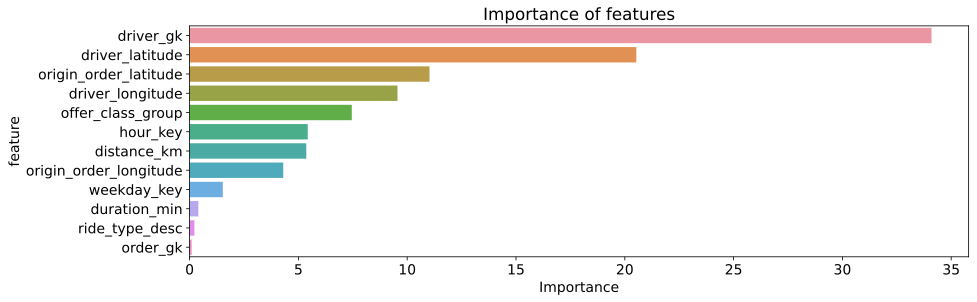

In [44]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  cat_model.feature_importances_, 
                                                  get_top=15)

### Выбор порога вероятности для определения класса

In [45]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 6))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

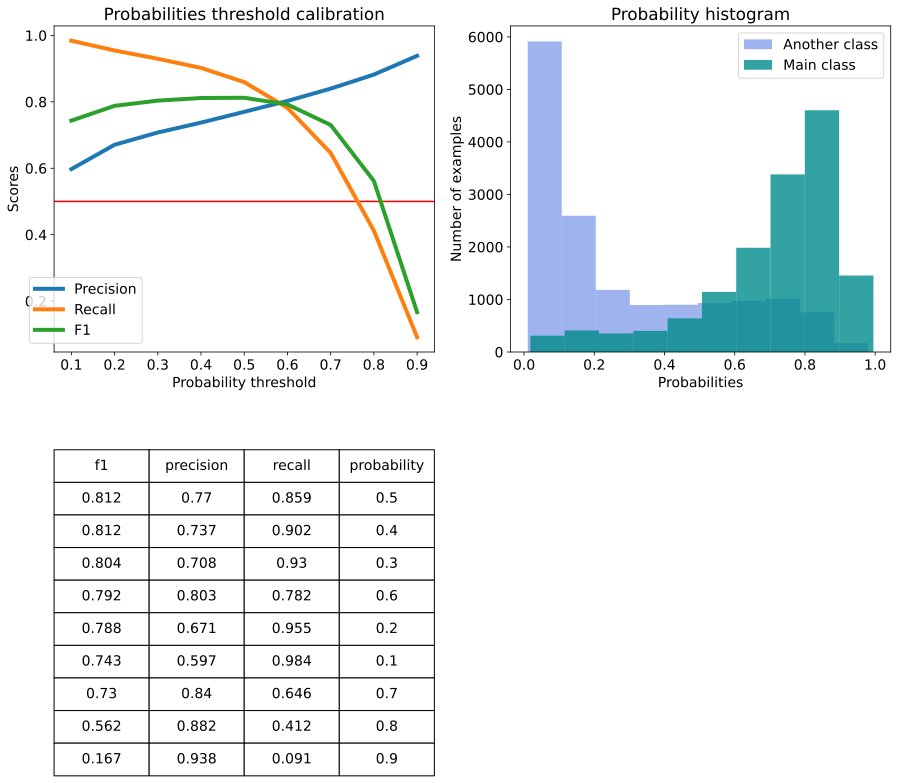

In [46]:
cat_model.fit(X_train, y_train, cat_features=cat_features)
y_test_pred_probs = cat_model.predict_proba(X_test)[:, 1]
show_proba_calibration_plots(y_test_pred_probs, y_test)

Из графика видно, что 0.6 является оптимальным параметром для порога вероятности.

In [47]:
y_test_labels = np.array(y_test_pred_probs > 0.6, dtype=int)
y_test_labels

array([0, 1, 1, ..., 1, 0, 1])

# Вывод: согласно полученным результатам наилучший результат по метрикам показал XGBoost. Однако тонкая настойка порога вероятности при определении класса в CatBoost также вероятно позволит улучшить результат модели